In [1]:
# OPF-driven MPC
    # For Resiliency Improvement in (Islanded) Distribution Systems
    # Objective:
        # maximize the total /priority-weighted/ load (active and reactive) served
        # penalize restored load shedding
        # penalize wind and pv power curtailment
# The distribution grid model is written in Julia
# The MPC is written in Julia 
# The data analytics (pre/post-processing) and forecasts are written in Python
# The MPC calling is written in Python (this notebook)

# Three-phase balanced distribution system
# Also includes MPC Validation against OpenDSS

In [2]:
# Import required Python packages/modules

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
#sbn.set()
from datetime import datetime
import os
import opendssdirect as dss

In [3]:
# Calling Julia Packages from Python
# Install Julia packages required by PyJulia

import julia
from julia.api import Julia
jl = Julia(compiled_modules=False)  
jl = julia.Julia()

In [4]:
# Include the Julia codes
    # Data preprocessing code
    # MPC code
    
jl.include("data_handler_threephase.jl");
jl.include("lr_threephase_opf_mpc.jl");

/Users/aeseye/.local/lib/python3.7/site-packages/julia/core.py:689: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  FutureWarning,


In [5]:
# Get the current directory

cur_dir = os.getcwd()

# Default/base network data (if any)

DATA_DIR = "basecase"

In [6]:
# Parameters

Δt = 5/60
SOC0 = 90

# Base values

Zbase = 1
Vbase = 4160
Sbase = (Vbase**2)/Zbase
Cbase = 800

In [7]:
# Get the the distribution grid information to the MPC

BUSES, LINES, GENERATORS, WINDTURBINES, PVS, STORAGES = jl.load_case_data(datafile="13buscase")

In [8]:
# Exogenous data - wind and pv profiles - forecasts

# Forecast (Wind & PV) Reader 

# Change the current path to the exogenous data path
exo_data_path = os.chdir('dataset/exogenous_data')

class ForecastReader:
    def __init__(self, forecast_pointers_file='forecast_pointers.csv'):
        self._forecast_pointers = pd.read_csv(forecast_pointers_file, parse_dates=['Time'],
                                        index_col=0, infer_datetime_format=True).to_dict()['forecast_file']

    def get_forecast(self, datetime):
        '''
        Get the forecast as a pandas dataframe for the datetime
        '''
        k = pd.Timestamp(datetime)

        if k not in self._forecast_pointers:
            raise Exception(f"Datetime {datetime} does not have a forecast available")

        return pd.read_csv(self._forecast_pointers[k], parse_dates=['Time'], index_col=0, infer_datetime_format=True)

    def available_dates(self):
        return self._forecast_pointers.keys()

# Get the dates of interest (dates in the control horizon)

# Specify the starting point for the forecasts
    # 2019-08-03 12:00 for paper results
Start_index = 31*24*12 + 2*24*12 + 144    # 2019-08-03 12:00  
#Start_index = 31*24*12 + 3*24*12 + 144-24    # 2019-08-04 10:00  
#Start_index = 31*24*12 + 1*24*12 + 0      # 2019-08-02 00:00 

# Define the optimization horizon (6 hours == 72 5-minutes)
num_time_steps = 12    # 72
dates_object = ForecastReader()
dates = dates_object.available_dates()
dateslist = list()
for time in dates:
    dateslist.append(time)
datetimes_6h = dateslist[Start_index:Start_index+num_time_steps]

# Get the PV and Wind forecasts
# and put together all the forecasts in all the time steps in the control horizon

# Define the rated capacities (kW) of the renewable generators
wind_mult = 150
pv_mult = 300

num_time_steps_in_a_day = 288
Pwind_forecast_all = np.empty((0, num_time_steps_in_a_day))
Psolar_forecast_all = np.empty((0, num_time_steps_in_a_day))

for datetime in datetimes_6h:
    # Read the Wind and PV Power Forecasts
    forecast_object = ForecastReader()
    forecast = forecast_object.get_forecast(datetime)
    Pwind = wind_mult*np.array(forecast['wind_gen'])
    Pwind_forecast_all = np.append(Pwind_forecast_all, [Pwind], axis=0)
    Psolar = pv_mult*np.array(forecast['pv_gen'])
    Psolar_forecast_all = np.append(Psolar_forecast_all, [Psolar], axis=0)
    

In [9]:
# Print the date and timestamps picked up

datetimes_6h

[Timestamp('2019-08-03 12:00:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:05:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:10:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:15:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:20:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:25:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:30:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:35:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:40:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:45:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:50:00+0000', tz='UTC'),
 Timestamp('2019-08-03 12:55:00+0000', tz='UTC')]

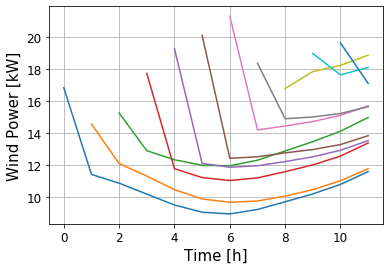

forecasted_wind_energy_kWh:  88.0181072229058


In [10]:
# Extract the Wind Forecasts at each time interval

forecasted_wind_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the wind at each step
    
    #wind = Pwind_forecast_all[idx, idx:72]
    wind = Pwind_forecast_all[idx, 0:num_time_steps-idx]
    
    forecasted_wind_energy = forecasted_wind_energy + sum(wind)*Δt
    
    plt.plot(T[idx:], wind)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Wind Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()
    
print('forecasted_wind_energy_kWh: ', forecasted_wind_energy)

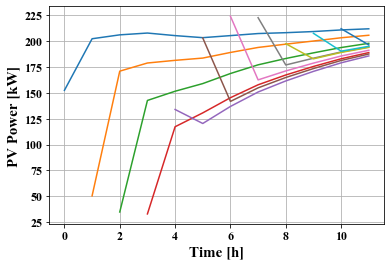

forecasted_solar_energy_kWh:  1147.2206000089354


In [11]:
# Extract the PV Forecasts at each time interval

forecasted_solar_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the PV power at each step
    
    pv = Psolar_forecast_all[idx, 0:num_time_steps-idx]
    
    forecasted_solar_energy = forecasted_solar_energy + sum(pv)*Δt

    plt.plot(T[idx:], pv)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('PV Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('forecasted_solar_energy_kWh: ', forecasted_solar_energy)

In [12]:
# Exogenous data - actual wind and pv profiles 

exo_data_path = cur_dir+"/five_min_renewable_profile.csv"


exo_data = pd.read_csv(exo_data_path, index_col=0)

start_idx = 0
duration = num_time_steps_in_a_day

wind_profile = exo_data["wind_gen"][start_idx:start_idx+duration]
pv_profile = exo_data["pv_gen"][start_idx:start_idx+duration]

wind_mult = 150
pv_mult = 300

wind = wind_mult * wind_profile
pv = pv_mult * pv_profile

Pwt = 1000 * wind /Sbase
Ppv = 1000 * pv /Sbase


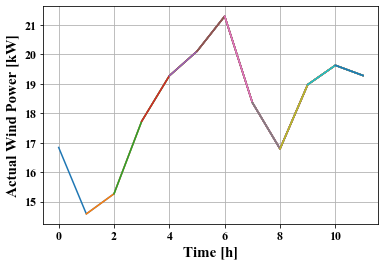

actual_wind_energy_kWh:  121.99765625000003


In [13]:
# Extract the actual wind power

#starttime = "2019-08-02 00:00:00"  # Over-forecasted case
#stoptime = "2019-08-02 06:00:00"

starttime = "2019-08-03 12:00:00"   # Under-forecasted case
stoptime = "2019-08-03 18:00:00"

#starttime = "2019-08-04 10:00:00"   # Over
#stoptime = "2019-08-04 16:00:00"

wind1 = wind_mult*pd.DataFrame(exo_data[starttime:stoptime])['wind_gen']

actual_wind_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the wind at each step
    
    wind_act = wind1[idx:num_time_steps]
    
    actual_wind_energy = actual_wind_energy + sum(wind_act)*Δt

    plt.plot(T[idx:], wind_act)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Actual Wind Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('actual_wind_energy_kWh: ', actual_wind_energy)

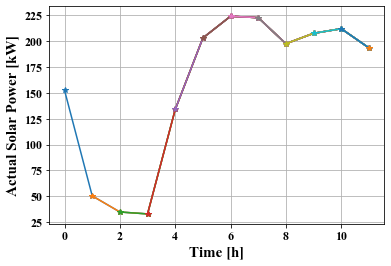

actual_solar_energy_kWh:  1186.3683127499999


In [14]:
# Actual PV Power

pv1 = pv_mult*pd.DataFrame(exo_data[starttime:stoptime])['pv_gen']

actual_solar_energy = 0 
T = range(num_time_steps)
for idx in T:

    # Update the wind at each step
    
    pv_act = pv1[idx:num_time_steps]
    
    actual_solar_energy = actual_solar_energy + sum(pv_act)*Δt

    #plt.plot(T[idx:], wind_act, marker='*')
    plt.plot(T[idx:], pv_act, marker='*')
    plt.ylabel('Actuals [kW]', fontsize=15)
    #plt.plot(T[idx:], wind, marker='o')

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Actual Solar Power [kW]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()

print('actual_solar_energy_kWh: ', actual_solar_energy)

In [15]:
forecasted_energy_kWh = forecasted_wind_energy + forecasted_solar_energy
actual_energy_kWh = actual_wind_energy + actual_solar_energy
forecast_error = actual_energy_kWh - forecasted_energy_kWh
forecast_error

73.12726176815863

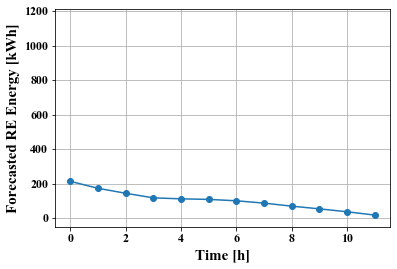

In [16]:
# Plot the RE energy forecast at each step

T = range(num_time_steps)
forecasted_tot_wind_energy = ([])
forecasted_tot_solar_energy = ([])
for idx in T:

    # Update the wind at each step
    
    wind = Pwind_forecast_all[idx, 0:num_time_steps-idx]
    pv = Psolar_forecast_all[idx, 0:num_time_steps-idx]
    
    forecasted_tot_wind_energy = np.append(forecasted_tot_wind_energy, sum(wind)*Δt)
    forecasted_tot_solar_energy = np.append(forecasted_tot_solar_energy, sum(pv)*Δt)

forecasted_tot_re_energy = forecasted_tot_wind_energy + forecasted_tot_solar_energy
plt.plot(forecasted_tot_re_energy, marker='o')
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Forecasted RE Energy [kWh]', fontsize=15)
plt.ylim((-50, 1210))
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(10*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


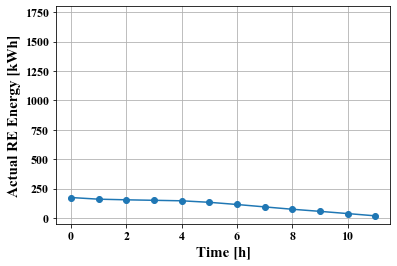

In [17]:
# Plot the RE energy actual at each step

wind1 = wind_mult*pd.DataFrame(exo_data[starttime:stoptime])['wind_gen']
pv1 = pv_mult*pd.DataFrame(exo_data[starttime:stoptime])['pv_gen']

T = range(num_time_steps)
actual_tot_wind_energy = ([])
actual_tot_solar_energy = ([])
for idx in T:

    # Update the wind at each step
    
    wind_act = wind1[idx:num_time_steps]
    pv_act = pv1[idx:num_time_steps]
    
    actual_tot_wind_energy = np.append(actual_tot_wind_energy, sum(wind_act)*Δt)
    actual_tot_solar_energy = np.append(actual_tot_solar_energy, sum(pv_act)*Δt)
    
actual_tot_re_energy = actual_tot_wind_energy + actual_tot_solar_energy
plt.plot(actual_tot_re_energy, marker='o')
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Actual RE Energy [kWh]', fontsize=15)
plt.ylim((-50, 1800))
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(10*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


In [18]:
# Load demand time series in per unit (pu)

d_P = np.zeros((len(BUSES), num_time_steps_in_a_day))
d_Q = np.zeros((len(BUSES), num_time_steps_in_a_day))
for b in jl.keys(BUSES):
    for t in range(num_time_steps_in_a_day):
        if b == 2:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 3:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q 
        if b == 4:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 6:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 7:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 9:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 10:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 11:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q
        if b == 12:
            d_P[b,t] = BUSES[b].d_P
            d_Q[b,t] = BUSES[b].d_Q

Pd = d_P       # active_power_demand
Qd = d_Q;      # reactive_power_demand

# Total active power demand at each time step

P_d_tot = np.zeros((num_time_steps_in_a_day))
for jdx in range(num_time_steps_in_a_day):
    P_d_tot[jdx] = np.sum(Pd[:,jdx]) 


Q_d_tot = np.zeros((num_time_steps_in_a_day))
for jdx in range(num_time_steps_in_a_day):
    Q_d_tot[jdx] = np.sum(Qd[:,jdx]) 

# Number of buses

num_buses = len(BUSES)

# Number of load buses

load_buses = jl.findall(Pd[:,0] != 0.0)
num_load_buses = len(load_buses)


In [19]:
## Run the MPC

# Inputs to MPC

es_soc = 90
mt_energy = 1000
active_power_demanded = Pd
reactive_power_demanded = Qd
active_power_restored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
reactive_power_restored = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

num_buses = len(BUSES)
num_lines = len(LINES)
num_lines_singlePhase = 3*num_lines

# // Set array to store the MPC results

Pmtt = ([])
Qmtt = ([])

Pess = ([])
Qess = ([])
SOCes = ([])

Pwt_cutt = ([])
Ppv_cutt = ([])
Pwt_instant = ([])
Ppv_instant = ([])
#Qwt_invv = ([])
#Qpv_invv = ([])

Pd_instant = np.empty((0, num_buses))
Qd_instant = np.empty((0, num_buses))

P_restoredd = np.empty((0, num_buses))
Q_restoredd = np.empty((0, num_buses))

mu_PP = np.empty((0, num_buses))
mu_QQ = np.empty((0, num_buses))

Pwt_instant = ([])
Ppv_instant = ([])

from_bus = np.empty((num_lines))
to_bus = np.empty((num_lines))
P_line = np.empty((0, num_lines))
Q_line = np.empty((0, num_lines))

volts = np.empty((0, num_buses))

# Initial control horizon

control_horizon = num_time_steps

# Call the MPC

for i in range(num_time_steps):

    # Update the wind and PV power at each step
    
    wt_power = 1000*Pwind_forecast_all[i, 0:72]/Sbase
    pv_power = 1000*Psolar_forecast_all[i, 0:72]/Sbase
    
    objective_value, P_restored, Q_restored, Pmt, Qmt, Pwtb, Pwt_cut, Ppvs,\
    Ppv_cut, Pes, Qes, SOC_es, voltages, mu_P, mu_Q, frombus, tobus, P_lineflow, Q_lineflow =\
    jl.opf_mpc(BUSES, LINES, GENERATORS, WINDTURBINES, PVS, STORAGES, control_horizon, es_soc, mt_energy, wt_power, pv_power, active_power_demanded, reactive_power_demanded, active_power_restored, reactive_power_restored)
    
    # Apply the first control actions and discard the rest
    
    P_restoredd = np.append(P_restoredd, [P_restored[:,0]], axis=0)
    Q_restoredd = np.append(Q_restoredd, [Q_restored[:,0]], axis=0)
    
    mu_PP = np.append(mu_PP, [mu_P[:,0]], axis=0)
    mu_QQ = np.append(mu_QQ, [mu_Q[:,0]], axis=0)
    
    Pmtt = np.append(Pmtt, Pmt[0]) 
    Qmtt = np.append(Qmtt, Qmt[0])
    
    Pess = np.append(Pess, Pes[0])
    Qess = np.append(Qess, Qes[0])
    
    SOCes = np.append(SOCes, SOC_es[0])
    
    Pwt_cutt = np.append(Pwt_cutt, Pwt_cut[0])
    #Qwt_invv = np.append(Qwt_invv, Qwt_inv[0])
                         
    Ppv_cutt = np.append(Ppv_cutt, Ppv_cut[0])
    #Qpv_invv = np.append(Qpv_invv, Qpv_inv[0])
    
    P_line = np.append(P_line, [P_lineflow[:,0]], axis=0)
    Q_line = np.append(Q_line, [Q_lineflow[:,0]], axis=0)
    
    #from_bus = np.append(from_bus, frombus)|
    #to_bus = np.append(to_bus, tobus)
    
    volts = np.append(volts, [voltages[:,0]], axis=0)
    
    # Save the intant (current) values of the loads and RE generations 
        
    Pd_instant = np.append(Pd_instant, [active_power_demanded[:,0]], axis=0)
    Qd_instant = np.append(Qd_instant, [reactive_power_demanded[:,0]], axis=0)
    Pwt_instant = np.append(Pwt_instant, Pwtb[0])
    Ppv_instant = np.append(Ppv_instant, Ppvs[0])
    
    # Update the ES SOC and MT fuel status for the next step
    
    es_soc = SOC_es[0]
    mt_energy = mt_energy - Pmt[0]*Δt
    
    # Update the restored load for the next step
    
    active_power_restored = np.transpose(P_restored)[0]*1000/Sbase
    reactive_power_restored = np.transpose(Q_restored)[0]*1000/Sbase
    
    # Update (reduce) the control horizon for the next step
    
    control_horizon -=1
    
# END

Pd_instant = np.transpose(Pd_instant)
Qd_instant = np.transpose(Qd_instant)
P_restoredd = np.transpose(P_restoredd)
Q_restoredd = np.transpose(Q_restoredd)
volts = np.transpose(volts)
P_line = np.transpose(P_line)
Q_line = np.transpose(Q_line)
from_bus = frombus
to_bus = tobus

mu_PP = np.transpose(mu_PP)
mu_QQ = np.transpose(mu_QQ)


In [20]:
# Demanded power at each time step

P_demanded_t = ([])
for pdx in range(Pd_instant.shape[1]):
    P_demanded_t.append(sum(Pd_instant[:,pdx])*Sbase/1000)
    
Q_demanded_t = ([])
for qdx in range(Qd_instant.shape[1]):
    Q_demanded_t.append(sum(Qd_instant[:,qdx])*Sbase/1000)

# Restored load at each time step

P_restored_t = ([])
Q_restored_t = ([])
for jdx in range(num_time_steps):
    P_restored_t = np.append(P_restored_t, sum(P_restoredd[:,jdx]))
    Q_restored_t = np.append(Q_restored_t, sum(Q_restoredd[:,jdx]))
    
# Restored energy at each node

E_restored_n = ([])
for qdx in range(num_buses):
    E_restored_n = np.append(E_restored_n, sum(P_restoredd[qdx,:])*Δt)
    

In [21]:
# Demanded vs restored energy

demanded_energy = sum(P_demanded_t)*Δt
restored_energy = sum(P_restored_t)*Δt
print("demanded vs restored energy in kWh: ", demanded_energy, ", ", restored_energy)


demanded vs restored energy in kWh:  1207.5 ,  578.7556816387361


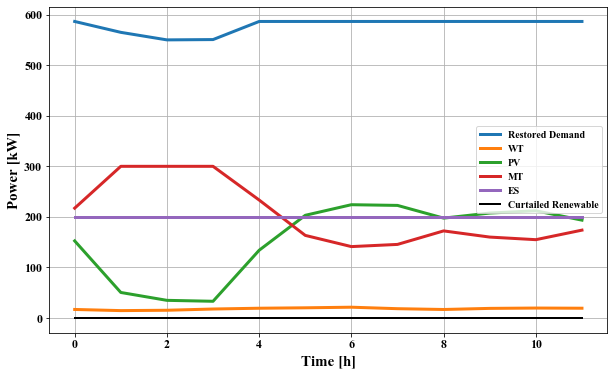

In [22]:
# Result Plots

# Active Power (kW)

plt.figure(figsize=(10,6))
#plt.plot(P_demanded_t, label='Requested Demand', linewidth = 3)
plt.plot(P_restored_t, label='Restored Demand', linewidth = 3)
plt.plot(Pwt_instant, label='WT', linewidth = 3)
plt.plot(Ppv_instant, label='PV', linewidth = 3)
plt.plot(Pmtt, label='MT', linewidth = 3)
plt.plot(Pess, label='ES', linewidth = 3)
plt.plot((Pwt_cutt + Ppv_cutt), label='Curtailed Renewable', linewidth = 2, color = 'black')

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kW]', fontsize=15)
#plt.title('Active Power Dispatch and Load Restoration', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
#plt.legend()
# (0.5, 5)
plt.legend()
#plt.legend(loc='upper center', bbox_to_anchor=(0.29, 1), fancybox=True, shadow=True, ncol=3)
plt.show()
#plt.savefig('/Users/aeseye/Desktop/Resuts_PES_GM_paper/Dispatch_P.pdf')


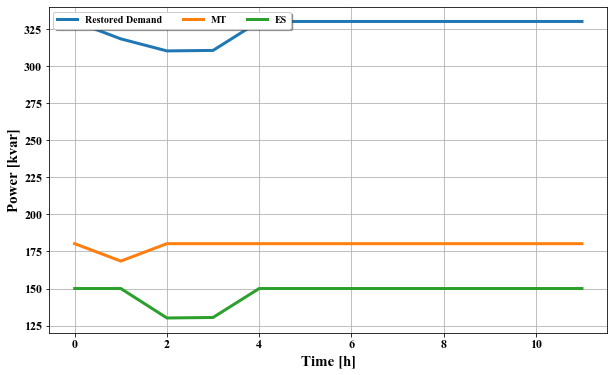

In [23]:
# Result Plots

# Reactive Power (kvar)

plt.figure(figsize=(10,6))
#plt.plot(Q_demanded_t, label='Requested Demand', linewidth = 3)
plt.plot(Q_restored_t, label='Restored Demand', linewidth = 3)
#plt.plot(Qwt_invv, label='WT', linewidth = 3)
#plt.plot(Qpv_invv, label='PV', linewidth = 3)
plt.plot(Qmtt, label='MT', linewidth = 3)
plt.plot(Qess, label='ES', linewidth = 3)

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Power [kvar]', fontsize=15)
#plt.title('Reactive Power Dispatch and Load Restoration', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
#plt.legend(loc='upper center', bbox_to_anchor=(1.13, 0.99), fancybox=True, shadow=True, ncol=1)
plt.legend(loc='upper center', bbox_to_anchor=(0.22, 1), fancybox=True, shadow=True, ncol=3)
plt.show()

#plt.savefig('/Users/aeseye/Desktop/Resuts_PES_GM_paper/Dispatch_Q.pdf')



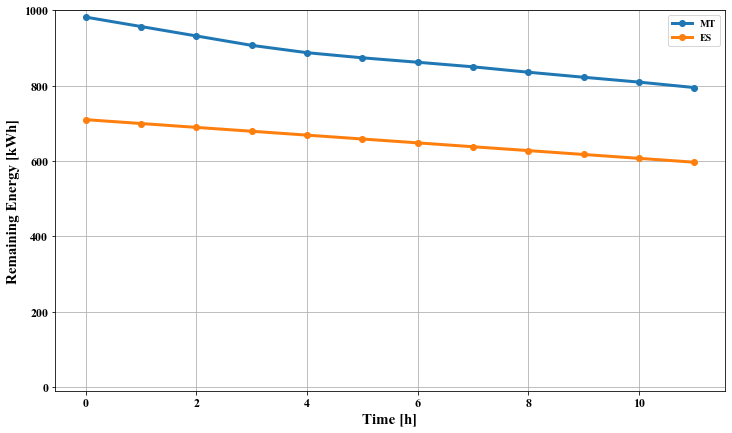

In [24]:
# Change in Energy of ES and MT

Emt_gen = ([])
Emt_gen = np.append(Emt_gen, 1000 - Pmtt[0]*Δt)
for v in range(1,num_time_steps):
    Emt_gen = np.append(Emt_gen, Emt_gen[v-1] - Pmtt[v]*Δt)

plt.figure(figsize=(12,7))
plt.plot(Emt_gen, label='MT', linewidth = 3, marker='o')
plt.plot(800*SOCes/100, label='ES', linewidth = 3, marker='o')
plt.xlabel('Time [h]', fontsize=15)
plt.ylim((-10, 1000))
plt.ylabel('Remaining Energy [kWh]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.legend()
plt.show()


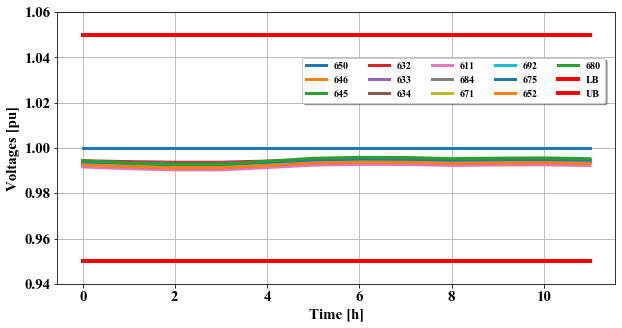

In [25]:
# Voltage Profiles

# ANSI voltage regulation limits (0.95, 1.05)

lower_vol_limit = 0.95
upper_vol_limit = 1.05
lb_volts = ([])
ub_volts = ([])
for j in range(num_time_steps):
    lb_volts = np.append(lb_volts, lower_vol_limit)
    ub_volts = np.append(ub_volts, upper_vol_limit)
    
#Buses = ['Bus1','Bus2','Bus3','Bus4','Bus5','Bus6','Bus7','Bus8','Bus9','Bus10','Bus11','Bus12','Bus13']
Buses = ['650','646','645','632','633','634','611','684','671','692','675','652','680']

plt.figure(figsize=(10,5))
for bx in range(len(volts)):
    plt.plot(volts[bx], label = Buses[bx], linewidth = 3)
plt.plot(lb_volts,  label = "LB", linewidth = 4, color="red") # label = "LB"
plt.plot(ub_volts, label = "UB", linewidth = 4, color="red") 
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Voltages [pu]', fontsize=15)
plt.tick_params(labelsize=15)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((0.94, 1.06))
plt.grid()
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.71, 0.85), fancybox=True, shadow=True, ncol=5)

plt.show()

#plt.savefig('/Users/aeseye/Desktop/Resuts_PES_GM_paper/voltages.pdf', legend=True)


In [26]:
# Line flows three-phase - MPC

P_flow_kW = {}
Q_flow_kvar = {}

P_flow_kW2 = {}
Q_flow_kvar2 = {}

i = 0
for n in range(len(from_bus)):
    P_flow_kW[from_bus[n], to_bus[n]] = P_line[n]
    Q_flow_kvar[from_bus[n], to_bus[n]] = Q_line[n]
    P_flow_kW2[n+1] = P_line[n]
    Q_flow_kvar2[n+1] = Q_line[n]
    i+=1

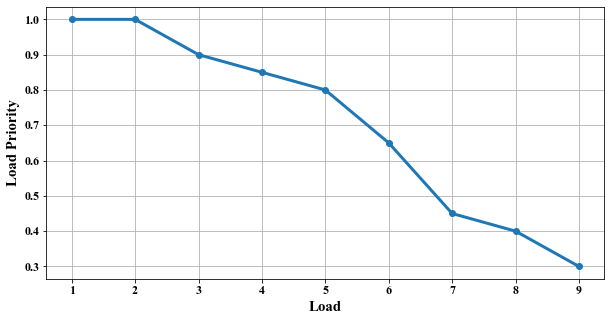

In [27]:
# Plot the Load Priority Weight

load_priority = [1.0, 1.0, 0.9, 0.85, 0.8, 0.65, 0.45, 0.4, 0.3]
#node_idx = range(num_load_buses)
#node_idx = np.array(node_idx)
plt.figure(figsize=(10,5))
plt.plot(load_priority, linewidth = 3, marker="o")
plt.xlabel('Load', fontsize=15)
plt.ylabel('Load Priority', fontsize=15)
plt.tick_params(labelsize=12)
plt.xticks(range(0, 9, 1), [str(int(c)) for c in range(1, 10, 1)])
plt.rcParams["font.family"] = "Times New Roman"
plt.grid()
plt.show()


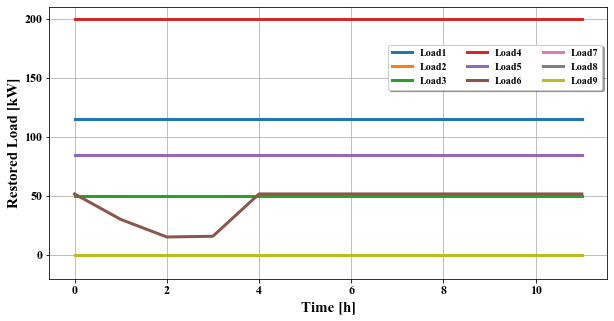

In [28]:
# Plot - restored loads (kW)

Loads = ['Load1','Load2','Load3','Load4','Load5','Load6','Load7','Load8','Load9']

plt.figure(figsize=(10,5))
#for bdx in range(num_buses):
#    plt.plot(P_restoredd[bdx], label = Loads[bdx], linewidth = 3)

plt.plot(P_restoredd[2], label = 'Load1', linewidth = 3)
plt.plot(P_restoredd[3], label = 'Load2', linewidth = 3)
plt.plot(P_restoredd[4], label = 'Load3', linewidth = 3)
plt.plot(P_restoredd[6], label = 'Load4', linewidth = 3)
plt.plot(P_restoredd[7], label = 'Load5', linewidth = 3)
plt.plot(P_restoredd[9], label = 'Load6', linewidth = 3)
plt.plot(P_restoredd[10], label = 'Load7', linewidth = 3)
plt.plot(P_restoredd[11], label = 'Load8', linewidth = 3)
plt.plot(P_restoredd[12], label = 'Load9', linewidth = 3)

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored Load [kW]', fontsize=15)
#plt.title('Restored Loads (Active Power) (kW)', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((-20, 210))
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.5), fancybox=True, shadow=True, ncol=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.799, 0.88), fancybox=True, shadow=True, ncol=3)
plt.show()

#plt.savefig('/Users/aeseye/Desktop/Resuts_PES_GM_paper/restored_load_kW.pdf')


/Users/aeseye/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


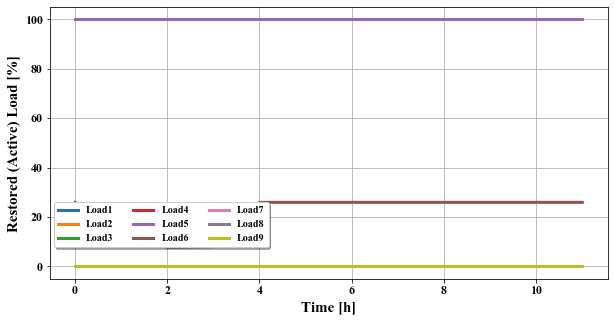

In [29]:
# Plot the percentage of the restored load per time step and node
    # %Restored Load = Restored Load/Actual Load Demand
    
P_restored_t_perc = (P_restoredd / (Pd*Sbase/1000)[:,0:num_time_steps]) *100

#for dx in range(len(P_restored_t_perc)):
#    plt.plot(P_restored_t_perc[dx], label = Nodes[dx], linewidth = 3)

plt.figure(figsize=(10,5))

plt.plot(P_restored_t_perc[2], label = 'Load1', linewidth = 3)
plt.plot(P_restored_t_perc[3], label = 'Load2', linewidth = 3)
plt.plot(P_restored_t_perc[4], label = 'Load3', linewidth = 3)
plt.plot(P_restored_t_perc[6], label = 'Load4', linewidth = 3)
plt.plot(P_restored_t_perc[7], label = 'Load5', linewidth = 3)
plt.plot(P_restored_t_perc[9], label = 'Load6', linewidth = 3)
plt.plot(P_restored_t_perc[10], label = 'Load7', linewidth = 3)
plt.plot(P_restored_t_perc[11], label = 'Load8', linewidth = 3)
plt.plot(P_restored_t_perc[12], label = 'Load9', linewidth = 3)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored (Active) Load [%]', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
#plt.title('Restored (Active) Loads in %')
plt.grid()
#plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.6), fancybox=True, shadow=True, ncol=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.2, 0.3), fancybox=True, shadow=True, ncol=3)
plt.show()

#plt.savefig('/Users/aeseye/Desktop/Resuts_PES_GM_paper/restored_load_kW.pdf')


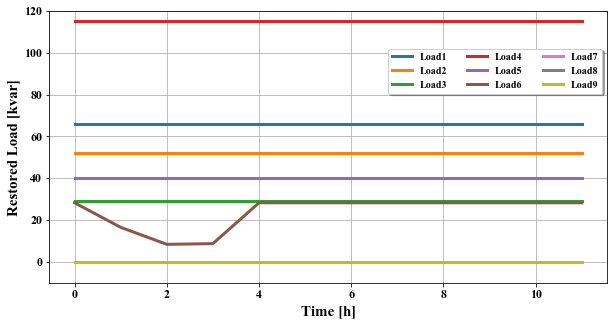

In [30]:
# Plot - restored loads (kvar)

Loads = ['Load1','Load2','Load3','Load4','Load5','Load6','Load7','Load8','Load9']

plt.figure(figsize=(10,5))
#for bdx in range(num_buses):
#    plt.plot(P_restoredd[bdx], label = Loads[bdx], linewidth = 3)

plt.plot(Q_restoredd[2], label = 'Load1', linewidth = 3)
plt.plot(Q_restoredd[3], label = 'Load2', linewidth = 3)
plt.plot(Q_restoredd[4], label = 'Load3', linewidth = 3)
plt.plot(Q_restoredd[6], label = 'Load4', linewidth = 3)
plt.plot(Q_restoredd[7], label = 'Load5', linewidth = 3)
plt.plot(Q_restoredd[9], label = 'Load6', linewidth = 3)
plt.plot(Q_restoredd[10], label = 'Load7', linewidth = 3)
plt.plot(Q_restoredd[11], label = 'Load8', linewidth = 3)
plt.plot(Q_restoredd[12], label = 'Load9', linewidth = 3)

plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored Load [kvar]', fontsize=15)
#plt.title('Restored Loads (kvar)', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((-10, 120))
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.799, 0.88), fancybox=True, shadow=True, ncol=3)
plt.show()

#plt.savefig('/Users/aeseye/Desktop/Resuts_PES_GM_paper/restored_load_kvar.pdf')


/Users/aeseye/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


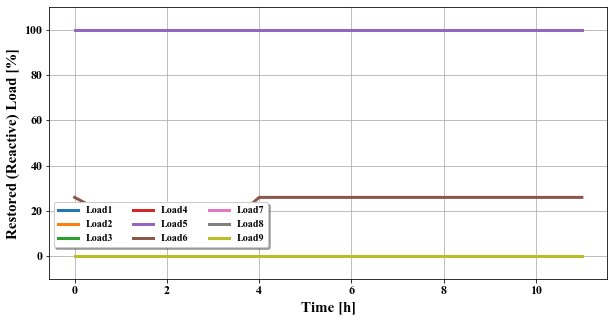

In [31]:
# Plot the percentage of the restored load per time step and node
    # %Restored Load = Restored Load/Actual Load Demand
    
Q_restored_t_perc = (Q_restoredd / (Qd*Sbase/1000)[:,0:num_time_steps]) *100

#for dx in range(len(P_restored_t_perc)):
#    plt.plot(P_restored_t_perc[dx], label = Nodes[dx], linewidth = 3)

plt.figure(figsize=(10,5))

plt.plot(Q_restored_t_perc[2], label = 'Load1', linewidth = 3)
plt.plot(Q_restored_t_perc[3], label = 'Load2', linewidth = 3)
plt.plot(Q_restored_t_perc[4], label = 'Load3', linewidth = 3)
plt.plot(Q_restored_t_perc[6], label = 'Load4', linewidth = 3)
plt.plot(Q_restored_t_perc[7], label = 'Load5', linewidth = 3)
plt.plot(Q_restored_t_perc[9], label = 'Load6', linewidth = 3)
plt.plot(Q_restored_t_perc[10], label = 'Load7', linewidth = 3)
plt.plot(Q_restored_t_perc[11], label = 'Load8', linewidth = 3)
plt.plot(Q_restored_t_perc[12], label = 'Load9', linewidth = 3)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('Restored (Reactive) Load [%]', fontsize=15)
plt.tick_params(labelsize=12)
plt.ylim((-10, 110))
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
#plt.title('Restored Loads (Reactive Power) in %')
plt.grid()
#plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.6), fancybox=True, shadow=True, ncol=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.2, 0.3), fancybox=True, shadow=True, ncol=3)
plt.show()

#plt.savefig('/Users/aeseye/Desktop/Resuts_PES_GM_paper/restored_load_kvar.pdf')


In [32]:
# END

In [33]:
# Restored energy

load_priority = [0.0, 0.0, 1.0, 1.0, 0.9, 0.0, 0.85, 0.8, 0.0, 0.65, 0.45, 0.4, 0.3]

Priorized_total_restored_load = Δt*sum(np.dot(load_priority, P_restoredd))
print("Priorized_total_restored_load: ", Priorized_total_restored_load)


Priorized_total_restored_load:  511.3786930651787


In [34]:
# Penalty for gradual increase in load shedding

psi = 100

l1 = ([])
for pp in range(1,len(P_restoredd[2])):
    if P_restoredd[2][pp] >= P_restoredd[2][pp-1]:
        dd = 0
        l1 = np.append(l1, dd)
    if P_restoredd[2][pp] < P_restoredd[2][pp-1]:
        dd = P_restoredd[2][pp-1] - P_restoredd[2][pp]
        l1 = np.append(l1, dd)
penalty1 = Δt*psi*load_priority[2]*sum(l1)

l2 = ([])
for pp in range(1,len(P_restoredd[3])):
    if P_restoredd[3][pp] >= P_restoredd[3][pp-1]:
        dd = 0
        l2 = np.append(l2, dd)
    if P_restoredd[3][pp] < P_restoredd[3][pp-1]:
        dd = P_restoredd[3][pp-1] - P_restoredd[3][pp]
        l2 = np.append(l2, dd)
penalty2 = Δt*psi*load_priority[3]*sum(l2)

l3 = ([])
for pp in range(1,len(P_restoredd[4])):
    if P_restoredd[4][pp] >= P_restoredd[4][pp-1]:
        dd = 0
        l3 = np.append(l3, dd)
    if P_restoredd[4][pp] < P_restoredd[4][pp-1]:
        dd = P_restoredd[4][pp-1] - P_restoredd[4][pp]
        l3 = np.append(l3, dd)
penalty3 = Δt*psi*load_priority[4]*sum(l3)

l4 = ([])
for pp in range(1,len(P_restoredd[6])):
    if P_restoredd[6][pp] >= P_restoredd[6][pp-1]:
        dd = 0
        l4 = np.append(l4, dd)
    if P_restoredd[6][pp] < P_restoredd[6][pp-1]:
        dd = P_restoredd[6][pp-1] - P_restoredd[6][pp]
        l4 = np.append(l4, dd)
penalty4 = Δt*psi*load_priority[6]*sum(l4)

l5 = ([])
for pp in range(1,len(P_restoredd[7])):
    if P_restoredd[7][pp] >= P_restoredd[7][pp-1]:
        dd = 0
        l5 = np.append(l5, dd)
    if P_restoredd[7][pp] < P_restoredd[7][pp-1]:
        dd = P_restoredd[7][pp-1] - P_restoredd[7][pp]
        l5 = np.append(l5, dd)
penalty5 = Δt*psi*load_priority[7]*sum(l5)

l6 = ([])
for pp in range(1,len(P_restoredd[9])):
    if P_restoredd[9][pp] >= P_restoredd[9][pp-1]:
        dd = 0
        l6 = np.append(l6, dd)
    if P_restoredd[9][pp] < P_restoredd[9][pp-1]:
        dd = P_restoredd[9][pp-1] - P_restoredd[9][pp]
        l6 = np.append(l6, dd)
penalty6 = Δt*psi*load_priority[9]*sum(l6)

l7 = ([])
for pp in range(1,len(P_restoredd[10])):
    if P_restoredd[10][pp] >= P_restoredd[10][pp-1]:
        dd = 0
        l7 = np.append(l7, dd)
    if P_restoredd[10][pp] < P_restoredd[10][pp-1]:
        dd = P_restoredd[10][pp-1] - P_restoredd[10][pp]
        l7 = np.append(l7, dd)
penalty7 = Δt*psi*load_priority[10]*sum(l7)

l8 = ([])
for pp in range(1,len(P_restoredd[11])):
    if P_restoredd[11][pp] >= P_restoredd[11][pp-1]:
        dd = 0
        l8 = np.append(l8, dd)
    if P_restoredd[11][pp] < P_restoredd[11][pp-1]:
        dd = P_restoredd[11][pp-1] - P_restoredd[11][pp]
        l8 = np.append(l8, dd)
penalty8 = Δt*psi*load_priority[11]*sum(l8)

l9 = ([])
for pp in range(1,len(P_restoredd[12])):
    if P_restoredd[12][pp] >= P_restoredd[12][pp-1]:
        dd = 0
        l9 = np.append(l9, dd)
    if P_restoredd[12][pp] < P_restoredd[12][pp-1]:
        dd = P_restoredd[12][pp-1] - P_restoredd[12][pp]
        l9 = np.append(l9, dd)
penalty9 = Δt*psi*load_priority[12]*sum(l9)

LoadSheddingInceasePenalties = [penalty1, penalty2, penalty3, penalty4, penalty5, penalty6, 
                                penalty7, penalty8, penalty9]

# Total Penalty

LoadSheddingInceasePenalty = sum(LoadSheddingInceasePenalties)

print("LoadSheddingInceasePenalty: ", LoadSheddingInceasePenalty)


LoadSheddingInceasePenalty:  197.33749814100986


In [35]:
# Penalty for renewable power curtailment

alpha = 0.2  #$/kWh
Penalized_total_wind_curtailment = alpha*sum(Pwt_cutt)*Δt
print("Wind Curtailment Penalty", Penalized_total_wind_curtailment)

beta = 0.2  #$/kWh
Penalized_total_pv_curtailment = beta*sum(Ppv_cutt[1:num_time_steps])*Δt
print("PV Curtailment Penalty", Penalized_total_pv_curtailment)

Penalized_RE_curtailment = Penalized_total_wind_curtailment + Penalized_total_pv_curtailment

print("RE Curtailment Penalty", Penalized_RE_curtailment)


Wind Curtailment Penalty 0.0
PV Curtailment Penalty 2.0906566966073834e-13
RE Curtailment Penalty 2.0906566966073834e-13


In [36]:
# Objective Function Value

Objective_fn_value = Priorized_total_restored_load - LoadSheddingInceasePenalty - Penalized_RE_curtailment
print("Objective Function Value: ", Objective_fn_value)

Objective Function Value:  314.0411949241686


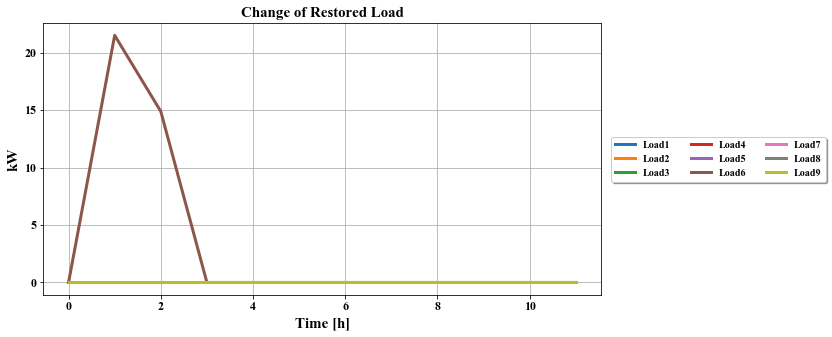

In [37]:
# Plot the change of restored load over time

plt.figure(figsize=(10,5))

mu_PP = mu_PP*Sbase/1000

plt.plot(mu_PP[2], label = 'Load1', linewidth = 3)
plt.plot(mu_PP[3], label = 'Load2', linewidth = 3)
plt.plot(mu_PP[4], label = 'Load3', linewidth = 3)
plt.plot(mu_PP[6], label = 'Load4', linewidth = 3)
plt.plot(mu_PP[7], label = 'Load5', linewidth = 3)
plt.plot(mu_PP[9], label = 'Load6', linewidth = 3)
plt.plot(mu_PP[10], label = 'Load7', linewidth = 3)
plt.plot(mu_PP[11], label = 'Load8', linewidth = 3)
plt.plot(mu_PP[12], label = 'Load9', linewidth = 3)
    
plt.xlabel('Time [h]', fontsize=15)
plt.ylabel('kW', fontsize=15)
plt.tick_params(labelsize=12)
#plt.ylim((-10, 110))
#plt.xticks(range(0, 73, 12), [str(int(c/12)) + ":00" for c in range(12*12, 12*72, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.title('Change of Restored Load', fontsize=15)
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(1.21, 0.6), fancybox=True, shadow=True, ncol=3)
plt.show()


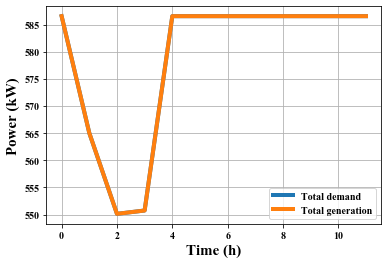

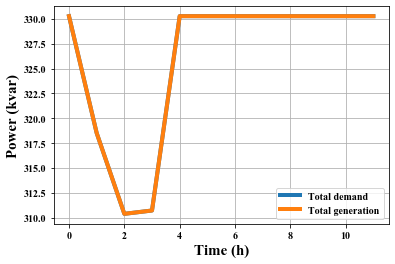

In [38]:
# Check the power balance

# Total demand

Pd_tot = P_restored_t
Qd_tot  = Q_restored_t

# Total Generation

Pg_tot = Pmtt + Pess + Pwt_instant - Pwt_cutt + Ppv_instant - Ppv_cutt 
Qg_tot = Qmtt + Qess

#plt.figure(figsize=(10,5))
plt.plot(Pd_tot, linewidth = 4, label = 'Total demand')
plt.plot(Pg_tot, linewidth = 4, label = 'Total generation')
plt.xlabel('Time (h)', fontsize=15)
plt.ylabel('Power (kW)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

#plt.figure(figsize=(10,5))
plt.plot(Qd_tot, linewidth = 4, label = 'Total demand')
plt.plot(Qg_tot, linewidth = 4, label = 'Total generation')
plt.xlabel('Time (h)', fontsize=15)
plt.ylabel('Power (kvar)', fontsize=15)
plt.legend()
plt.grid()
plt.show()


In [39]:
# Bus names
busNamesCsv = ['650', '646', '645', '632', '633', '634',\
               '611', '684', '671', '692', '675', '652', '680']

# Buses order dict
BusNameToIndexCsv = {}
IndexToBusNameCsv = {}
j=1
for name in busNamesCsv:
    BusNameToIndexCsv[name] = j
    IndexToBusNameCsv[j] = name
    j+=1

# Node names
nodeNamesCsv = []
for bus in busNamesCsv:
    for phase in range(1,4):
        nodeName = bus+'.'+str(phase)
        nodeNamesCsv.append(nodeName)

# Nodes order dict
NameToIndexCsv = {}
j=1
for name in nodeNamesCsv:
    NameToIndexCsv[name] = j
    j+=1

# Map from_bus to fromnode
fromNodeNames = []
for b_idx in from_bus:
    busName = IndexToBusNameCsv[b_idx]    
    for phase in range(1,4):
        nodeName = busName+'.'+str(phase)
        fromNodeNames.append(nodeName)

fromnode = []
for node in fromNodeNames:
    node_idx = NameToIndexCsv[node]
    fromnode.append(node_idx)
fromnode = np.array(fromnode)

# Map to_bus to tonode
toNodeNames = []
for b_idx in to_bus:
    busName = IndexToBusNameCsv[b_idx]
    for phase in range(1,4):
        nodeName = busName+'.'+str(phase)
        toNodeNames.append(nodeName)
    
tonode = []
for node in toNodeNames:
    node_idx = NameToIndexCsv[node]
    tonode.append(node_idx)
tonode = np.array(tonode)

In [40]:
# Demanded loads (three-phase loads) 
demanded_load_kW = Pd_instant*Sbase/1000
demanded_load_kvar = Qd_instant*Sbase/1000

# Restored loads (three-phase loads) by the MPC
restored_load_kW = P_restoredd
restored_load_kvar = Q_restoredd

In [41]:
# Get the MPC DER set-points (note that all the DERs are three-phase)

# Microturbine
Pmt_sp = Pmtt
Qmt_sp = Qmtt

# Wind
Ppv_sp = Ppv_instant - Ppv_cutt

# PV
Pwt_sp = Pwt_instant - Pwt_cutt

# Storage
Pes_sp = Pess
Qes_sp = Qess

In [42]:
# Get the node voltages - from the bus voltages
    # In a three-phase balanced system, the phase voltages are equal in magnitude 

# Bus voltages
busVoltages = {}
b = 0
for bus in busNamesCsv:
    busVoltages[bus] = volts[b]
    b+=1
    
# Nodal voltages
nodaVoltages = {}
for bus in busNamesCsv:
    for phase in range(1,4):
        nodeName = bus+'.'+str(phase)
        nodaVoltages[nodeName] = busVoltages[bus]
    
volts_mpc_sorted = ([])
for name in nodeNamesCsv:
    volts_mpc_sorted.append(nodaVoltages[name])
volts_mpc_sorted = np.array(volts_mpc_sorted)

In [43]:
# Get the line flows per phase - from the three-phase line flows
    # In a three-phase balanced system, the power flow through each phase line is equal
    
# Line names
lineNamesCsv = ['632645', '632633', '633634', '645646', '650632', '684652',\
                '632671', '671684', '671680', '671692', '684611', '692675']

# Three-phase active and reactive power flows (in kW and kvar resp.)
lineFlow_kW = {}
lineFlow_kvar = {}
l = 0
for line in lineNamesCsv:
    lineFlow_kW['Line.'+line] = P_line[l]
    lineFlow_kvar['Line.'+line] = Q_line[l]
    l+=1
    
# Active and reactive power flows per phase
lineFlow_perPhase_kW = {}
lineFlow_perPhase_kvar = {}
lineNames_mpc = []
for line in lineNamesCsv:
    for phase in range(1,4):
        lineName = 'Line.'+line+'.'+str(phase)
        lineFlow_perPhase_kW[lineName] = lineFlow_kW['Line.'+line]/3
        lineFlow_perPhase_kvar[lineName] = lineFlow_kvar['Line.'+line]/3
        lineNames_mpc.append(lineName)
        
P_flow_kW_mpc = ([])
Q_flow_kvar_mpc = ([])
for line in lineNames_mpc:
    P_flow_kW_mpc.append(lineFlow_perPhase_kW[line])
    Q_flow_kvar_mpc.append(lineFlow_perPhase_kvar[line])
P_flow_kW_mpc = np.array(P_flow_kW_mpc)
Q_flow_kvar_mpc = np.array(Q_flow_kvar_mpc)

In [44]:
# Get the line flows per phase - from the three-phase line flows
    # In a three-phase balanced system, the power flow through each phase line is equal
    
# Line names
lineNamesCsv = ['632645', '632633', '633634', '645646', '650632', '684652',\
                '632671', '671684', '671680', '671692', '684611', '692675']

# Three-phase active and reactive power flows (in kW and kvar resp.)

Pline632633 = P_line[10]
Qline632633 = Q_line[10]

Pline633634 = P_line[10]
Qline633634 = Q_line[10]

Pline645646 = P_line[0]
Qline645646 = Q_line[0]

Pline632645 = restored_load_kW[3] + Pline645646
Qline632645 = restored_load_kvar[3] + Qline645646

Pline650632 = P_line[4]
Qline650632 = Q_line[4]

Pline684652 = P_line[5]
Qline684652 = Q_line[5]

Pline671680 = P_line[8]
Qline671680 = Q_line[8]

Pline671692 = P_line[11]
Qline671692 = Q_line[11]

Pline684611 = restored_load_kW[7]
Qline684611 = restored_load_kvar[7]

Pline671684 = restored_load_kW[12] + Pline684611
Qline671684 = restored_load_kvar[12] + Qline684611

Pline692675 = P_line[11]
Qline692675 = Q_line[11]

Pline632671 = Pline671680 + Pline671692 + Pline671684 + restored_load_kW[9] - Pes_sp
Qline632671 = Qline671680 + Qline671692 + Qline671684 + restored_load_kvar[9] - Qes_sp

# Active and reactive power flows per phase
lineFlow_perPhase_kW2 = {}
lineFlow_perPhase_kvar2 = {}
lineNames_mpc2 = []
for line in lineNamesCsv:
    if line == '632645':
        p = Pline632645
        q = Qline632645
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '632633':
        p = Pline632633
        q = Qline632633
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '633634':
        p = Pline633634
        q = Qline633634
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '645646':
        p = Pline645646
        q = Qline645646
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '650632':
        p = Pline650632
        q = Qline650632
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '684652':
        p = Pline684652
        q = Qline684652
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '632671':
        p = Pline632671
        q = Qline632671
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '671684':
        p = Pline671684
        q = Qline671684
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '671680':
        p = Pline671680
        q = Qline671680
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '671692':
        p = Pline671692
        q = Qline671692
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '684611':
        p = Pline684611
        q = Qline684611
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)
    elif line == '692675':
        p = Pline692675
        q = Qline692675
        for phase in range(1,4):
            lineName = 'Line.'+line+'.'+str(phase)
            lineFlow_perPhase_kW2[lineName] = p/3
            lineFlow_perPhase_kvar2[lineName] = q/3
            lineNames_mpc2.append(lineName)

P_flow_kW_mpc2 = ([])
Q_flow_kvar_mpc2 = ([])
for line in lineNames_mpc2:
    P_flow_kW_mpc2.append(lineFlow_perPhase_kW2[line])
    Q_flow_kvar_mpc2.append(lineFlow_perPhase_kvar2[line])
P_flow_kW_mpc2 = np.array(P_flow_kW_mpc2)
Q_flow_kvar_mpc2 = np.array(Q_flow_kvar_mpc2)       

In [45]:
# OpenDSS Simulation
    # Based on the MPC's DER power set-points and picked up loads

In [46]:
## Run the OpenDSS simulation with initial demanded loads

# Path of the feeder dss model
masterfile = "/Users/aeseye/Desktop/AGM-Resilience-Project/Github/Optimization_for_Grid_Resiliency/dataset/network_data/ieee_13node_DSS/master_islanded3_balanced_3phase.dss"

# Run/initialize the dss simulation with the original load demands
str_cmd = 'Compile {}'.format(masterfile)
dss.run_command(str_cmd)

# Node names in the same order as the nodal voltages (AllBusMagPu())
allNodeNames = dss.Circuit.AllNodeNames()

# Demanded/original loads (p and q) at bus
ld = dss.Loads.First()
while(ld):
    load_name = dss.Loads.Name()
    p = dss.Loads.kW()
    q = dss.Loads.kvar()
    print(load_name, " ", p, " ", q)
    ld = dss.Loads.Next()

632   49.75   29.0
671   199.75   109.0
634   200.0   115.0
645   85.0   52.0
646   115.0   66.0
692   85.0   45.0
675   324.0   141.0
611   85.0   40.0
652   64.0   43.0


In [47]:
# Run the OpenDSS simulation with the MPC's DER set-points and restored loads

volts_dss = np.empty((0, len(nodaVoltages)))

P_flow_kW_dss = np.zeros((num_lines_singlePhase, num_time_steps))
Q_flow_kvar_dss = np.zeros((num_lines_singlePhase, num_time_steps))

line_lossesP = ([])
line_lossesQ = ([])

slackP = ([])
slackQ = ([])

for i in range(num_time_steps):
     
    # Update the dss loads with the MPC restored loads
    
    ld = dss.Loads.First()
    while(ld):
        load_name = dss.Loads.Name()
        if load_name == '632':
            p = restored_load_kW[4,i]
            q = restored_load_kvar[4,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '671':
            p = restored_load_kW[9,i]
            q = restored_load_kvar[9,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)                  
        if load_name == '634':
            p = restored_load_kW[6,i]
            q = restored_load_kvar[6,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)         
        if load_name == '645':
            p = restored_load_kW[3,i]
            q = restored_load_kvar[3,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)  
        if load_name == '646':
            p = restored_load_kW[2,i]
            q = restored_load_kvar[2,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '692':
            p = restored_load_kW[10,i]
            q = restored_load_kvar[10,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)                 
        if load_name == '675':
            p = restored_load_kW[11,i]
            q = restored_load_kvar[11,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        if load_name == '611':
            p = restored_load_kW[7,i]
            q = restored_load_kvar[7,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)      
        if load_name == '652':
            p = restored_load_kW[12,i]
            q = restored_load_kvar[12,i]
            dss.Loads.kW(p)
            dss.Loads.kvar(q)
        ld = dss.Loads.Next()
        
    # Add the MPC DER set-points

        # MT at node 650
    dss.run_command(
        "New Generator.{gen_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
        model=1 conn=wye".format(
        gen_name='MT',
        bus_name='650.1.2.3',
        active_pwr=Pmt_sp[i],  
        reac_pwr=Qmt_sp[i]
        ))

    dss.run_command(
        "New Vsource.{vs_name} Bus1={bus_name} phases=3 basekv=4.16 angle=30\
        baseMVA=np.sqrt((Pmt_sp[i]/1000)**2 + (Qmt_sp[i]/1000)**2)\
        MVAsc3=np.sqrt((Pmt_sp[i]/1000)**2 + (Qmt_sp[i]/1000)**2)\
        MVAsc1=(np.sqrt((Pmt_sp[i]/1000)**2 + (Qmt_sp[i]/1000)**2))/3 pu=1.0 enabled=y ".format(
        vs_name='VS_MT',
        bus_name='650.1.2.3'
        ))

        # PV at node 680

    dss.run_command(
        "New Generator.{gen_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
        model=1 conn=wye".format(
        gen_name='PV',
        bus_name='680.1.2.3',
        active_pwr=Ppv_sp[i],  
        reac_pwr=0
        ))

        # Wind Turbine (WT) at node 675

    dss.run_command(
        "New Generator.{gen_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
        model=1 conn=wye".format(
        gen_name='WT',
        bus_name='675.1.2.3',
        active_pwr=Pwt_sp[i],  
        reac_pwr=0.0
        ))

        # Energy Storage (ES) at node 632
        
    if Pes_sp[i] > 0:
        dss.run_command(
            "New Generator.{gen_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            gen_name='ES',
            bus_name='671.1.2.3',
            active_pwr=Pes_sp[i],  
            reac_pwr=Qes_sp[i]
            ))
    else:
        dss.run_command(
            "New Load.{load_name} Bus1={bus_name} phases=3 kV=4.16 kW={active_pwr} kvar={reac_pwr}\
            model=1 conn=wye".format(
            load_name='ES',
            bus_name='671.1.2.3',
            active_pwr=-Pes_sp[i],  
            reac_pwr=0.0
            ))
        
    # Solve the power flow using the DSS

    dss.run_command('Solve mode=snap');
      
    # Voltage profiles at each node at the current time step

    voltages = dss.Circuit.AllBusMagPu()  
    voltages = voltages[3:]
    volts_dss = np.append(volts_dss, [voltages], axis=0)
    
    # Total line loss
    
    Sloss = dss.Circuit.LineLosses()
    Ploss = Sloss[0]
    Qloss = Sloss[1]
    line_lossesP = np.append(line_lossesP, Ploss)
    line_lossesQ = np.append(line_lossesQ, Qloss)
    
    # Power from the slack source (Vsource)
    
    Sslack = dss.Circuit.TotalPower()
    Pslack = Sslack[0]
    Qslack = Sslack[1]
    slackP = np.append(slackP, Pslack)
    slackQ = np.append(slackQ, Qslack)
    
    # Power flow through each line
    
    lineFlows_dss = {}
    lineNames_dss = []

    kW_lineFlows_dss = {}
    kvar_lineFlows_dss = {}

    allElements = dss.Circuit.AllElementNames()
    for element in allElements:
        if element[0:4] == 'Line':            
            dss.Circuit.SetActiveElement(element)
            line = dss.CktElement.Name()
            lineflow = dss.CktElement.Powers() # 3-ph
            lineFlows_dss[line] = lineflow   
            for phase in range(1,4):
                lineName = line+'.'+str(phase)
                lineNames_dss.append(lineName)
                if phase == 1:
                    kW_lineFlows_dss[lineName] = lineflow[phase-1]
                    kvar_lineFlows_dss[lineName] = lineflow[phase]
                elif phase == 2:
                    kW_lineFlows_dss[lineName] = lineflow[phase]
                    kvar_lineFlows_dss[lineName] = lineflow[phase+1]
                elif phase == 3:
                    kW_lineFlows_dss[lineName] = lineflow[phase+1]
                    kvar_lineFlows_dss[lineName] = lineflow[phase+2]         
    ##            
                       
    kW_lineFlows_dss_sorted = ([])
    kvar_lineFlows_dss_sorted = ([])
    for line in lineNames_dss:      
        kW_lineFlows_dss_sorted.append(kW_lineFlows_dss[line])
        kvar_lineFlows_dss_sorted.append(kvar_lineFlows_dss[line])
        
    kW_lineFlows_dss_sorted = np.array(kW_lineFlows_dss_sorted)
    kvar_lineFlows_dss_sorted = np.array(kvar_lineFlows_dss_sorted)
    
    P_flow_kW_dss[:,i] = kW_lineFlows_dss_sorted
    Q_flow_kvar_dss[:,i] = kvar_lineFlows_dss_sorted
    
# Voltage profiles at each node for the whole simulation step
volts_dss = np.transpose(volts_dss)

# Line flows dict
P_flow_kW_dss_dict = {}
Q_flow_kvar_dss_dict = {}
l = 0
for line in lineNames_dss: 
    P_flow_kW_dss_dict[line] = P_flow_kW_dss[l]
    Q_flow_kvar_dss_dict[line] = Q_flow_kvar_dss[l]
    l+=1

In [48]:
# Harmonize the node orders between the DSS and MPC (CSVs)

# DSS nodal voltages based on the DSS nodes order
NameToIndex = {}
IndexToName = {}
NameToVoltage = {}
i = 0
for name in allNodeNames[3:]:
    NameToIndex[name] = i
    NameToVoltage[name] = volts_dss[i]
    IndexToName[i] = name
    i+=1

# Reorder the DSS nodal voltages based on the MPC (CSVs) nodes order
NameCsvToVoltage = {}
for name in nodeNamesCsv:
    NameCsvToVoltage[name] = NameToVoltage[name]

# Nodal voltages array
volts_dss_sorted = ([])
for name in nodeNamesCsv:
    volts_dss_sorted.append(NameCsvToVoltage[name])
volts_dss_sorted = np.array(volts_dss_sorted)

# Reorder the DSS line flows based on the MPC lines order
P_flow_kW_dss_dict_mpcOrder = {}
Q_flow_kvar_dss_dict_mpcOrder = {}
for name in lineNames_mpc:
    P_flow_kW_dss_dict_mpcOrder[name] = P_flow_kW_dss_dict[name]
    Q_flow_kvar_dss_dict_mpcOrder[name] = Q_flow_kvar_dss_dict[name]
    
# Line flows array
P_flow_kW_dss_sorted = ([])
Q_flow_kvar_dss_sorted = ([])
for name in lineNames_mpc:
    P_flow_kW_dss_sorted.append(P_flow_kW_dss_dict_mpcOrder[name])
    Q_flow_kvar_dss_sorted.append(Q_flow_kvar_dss_dict_mpcOrder[name])
P_flow_kW_dss_sorted = np.array(P_flow_kW_dss_sorted)
Q_flow_kvar_dss_sorted = np.array(Q_flow_kvar_dss_sorted)

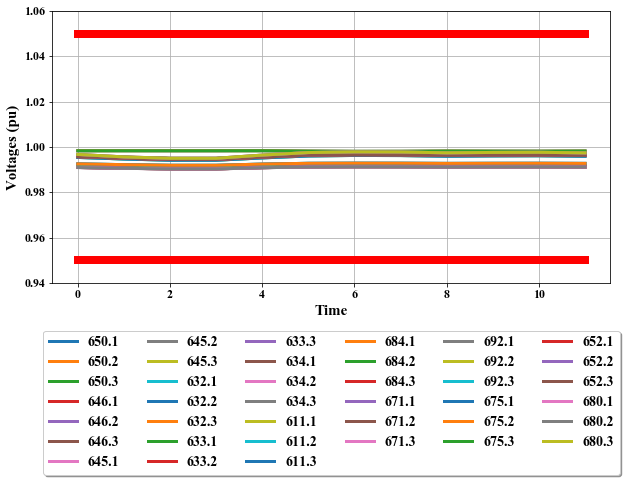

In [49]:
# Plot the OpenDSS nodal voltage results 

nodes = nodeNamesCsv

plt.figure(figsize=(10,5))
for k in range(volts_dss.shape[0]):
    plt.plot(volts_dss_sorted[k],linewidth = 3, label = nodes[k])
plt.xlabel('Time', fontsize=15)
plt.ylabel('Voltages (pu)', fontsize=15)
plt.tick_params(labelsize=12)
#plt.xticks(range(0, 289, 12), [str(int(a/12)) for a in range(0, 289, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(lb_volts, linewidth = 8, color = 'red')
plt.plot(ub_volts, linewidth = 8, color = 'red')
plt.ylim((0.94, 1.06))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.grid()
plt.show()

In [50]:
# Total demand
Pd_tot = P_restored_t
Qd_tot  = Q_restored_t

# Total Generation
Pg_tot = Pmt_sp + Ppv_sp + Pwt_sp + Pes_sp
Qg_tot = Qmt_sp + Qes_sp

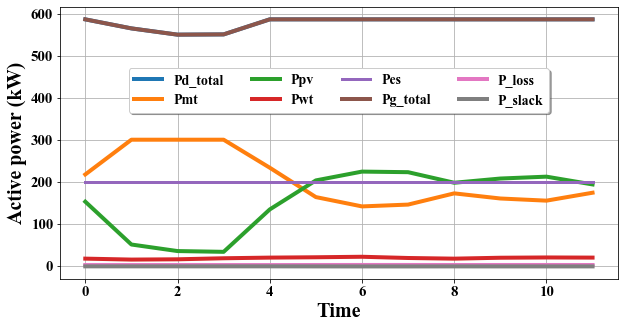

In [51]:
# Active power plot

plt.figure(figsize=(10,5))
plt.plot(Pd_tot,linewidth = 4, label = 'Pd_total')
plt.plot(Pmt_sp,linewidth = 4, label = 'Pmt')
plt.plot(Ppv_sp,linewidth = 4, label = 'Ppv')
plt.plot(Pwt_sp,linewidth = 4, label = 'Pwt')
plt.plot(Pes_sp,linewidth = 3, label = 'Pes')
plt.plot(Pg_tot,linewidth = 4, label = 'Pg_total')
plt.plot(line_lossesP,linewidth = 4, label = 'P_loss')
plt.plot(slackP,linewidth = 4, label = 'P_slack')
#plt.ylim((-500, 1700))
plt.xlabel('Time', fontsize=20)
plt.ylabel('Active power (kW)', fontsize=20)
plt.tick_params(labelsize=15)
#plt.xticks(range(0, 289, 12), [str(int(a/12)) for a in range(0, 289, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.8), fancybox=True, shadow=True, ncol=4, fontsize=14)
plt.grid()
plt.show()

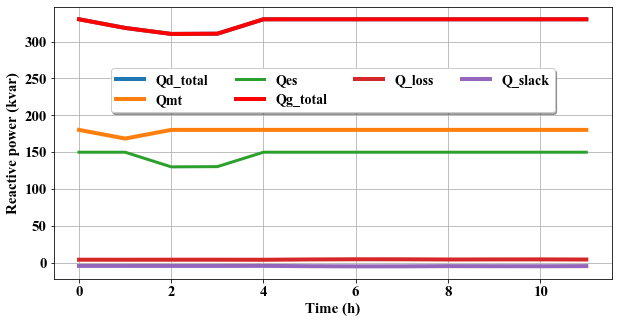

In [52]:
# Reactive Power Plot

plt.figure(figsize=(10,5))
plt.plot(Qd_tot,linewidth = 4, label = 'Qd_total')
plt.plot(Qmt_sp,linewidth = 4, label = 'Qmt')
plt.plot(Qes_sp,linewidth = 3, label = 'Qes')
plt.plot(Qg_tot,linewidth = 4, label = 'Qg_total', color='red')
plt.plot(line_lossesQ,linewidth = 4, label = 'Q_loss')
plt.plot(slackQ,linewidth = 4, label = 'Q_slack')
#plt.ylim((-100, 1400))
plt.xlabel('Time (h)', fontsize=15)
plt.ylabel('Reactive power (kvar)', fontsize=15)
plt.tick_params(labelsize=15)
#plt.xticks(range(0, 289, 12), [str(int(a/12)) for a in range(0, 289, 12)])
plt.rcParams["font.family"] = "Times New Roman"
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.8), fancybox=True, shadow=True, ncol=4, fontsize=14)
plt.grid()
plt.show()

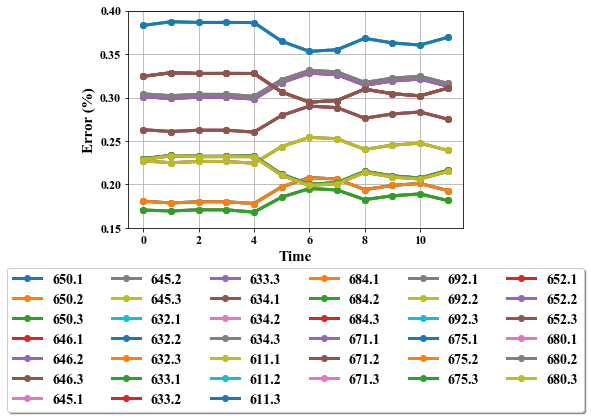

In [53]:
# Plot voltage error between MPC and DSS

voltages_dss = volts_dss_sorted
voltages_mpc = volts_mpc_sorted

err_voltages = 100*abs(voltages_dss - voltages_mpc)/voltages_dss

#plt.figure(figsize=(10,5))
for k in range(err_voltages.shape[0]):
    plt.plot(err_voltages[k],linewidth = 3, label = nodes[k], marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Error (%)', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((0.15, 0.40))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.grid()
plt.show()

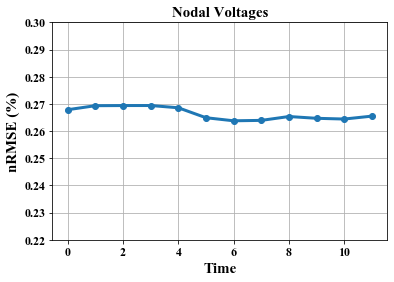

In [54]:
# Calculate the normalized root mean square error (nRMSE) for the nodal voltages:

import math

nRMSE_vol = []

for t in range(num_time_steps):
    MSE = np.square(np.subtract(voltages_dss[:,t],voltages_mpc[:,t])).mean() 
    RMSE = math.sqrt(MSE)
    nRMSE = 100*(RMSE/np.mean(voltages_dss[:,t]))
    nRMSE_vol.append(nRMSE)

#plt.figure(figsize=(8,4))
plt.plot(nRMSE_vol,linewidth = 3, marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('nRMSE (%)', fontsize=15)
plt.title('Nodal Voltages', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((0.22, 0.30))
plt.grid()
plt.show()

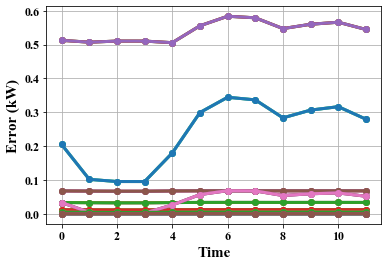

In [55]:
# Plot the active power flow error between MPC and DSS

err_activePower = abs(P_flow_kW_dss_sorted - P_flow_kW_mpc2)

#plt.figure(figsize=(8,4))
for k in range(err_activePower.shape[0]):
    plt.plot(err_activePower[k],linewidth = 3, marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Error (kW)', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
#plt.ylim((0, 7))
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.grid()
plt.show()

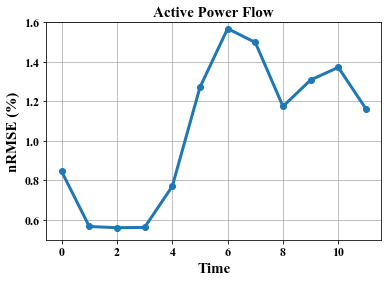

In [56]:
# Calculate the normalized root mean square error (nRMSE) for the active power flows:

import math

nRMSE_kW = []

for t in range(num_time_steps):
    MSE = np.square(np.subtract(P_flow_kW_dss_sorted[:,t],P_flow_kW_mpc2[:,t])).mean() 
    RMSE = math.sqrt(MSE)
    nRMSE = 100*(RMSE/np.mean(P_flow_kW_dss_sorted[:,t]))
    nRMSE_kW.append(nRMSE)

#plt.figure(figsize=(8,4))
plt.plot(nRMSE_kW,linewidth = 3, marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('nRMSE (%)', fontsize=15)
plt.title('Active Power Flow', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((0.50, 1.6))
plt.grid()

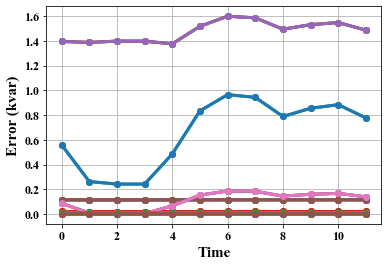

In [57]:
# Plot the reactive power flow error between MPC and DSS

err_reactivePower = abs(Q_flow_kvar_dss_sorted - Q_flow_kvar_mpc2)

#plt.figure(figsize=(8,4))
for k in range(err_reactivePower.shape[0]):
    plt.plot(err_reactivePower[k],linewidth = 3, marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Error (kvar)', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
#plt.ylim((0, 7))
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6, fontsize=14)
plt.grid()
plt.show()

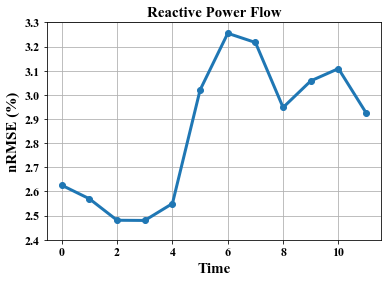

In [58]:
# Calculate the normalized root mean square error (nRMSE) for the active power flows:

import math

nRMSE_kvar = []

for t in range(num_time_steps):
    MSE = np.square(np.subtract(Q_flow_kvar_dss_sorted[:,t],Q_flow_kvar_mpc2[:,t])).mean() 
    RMSE = math.sqrt(MSE)
    nRMSE = 100*(RMSE/np.mean(Q_flow_kvar_dss_sorted[:,t]))
    nRMSE_kvar.append(nRMSE)

plt.plot(nRMSE_kvar,linewidth = 3, marker='o')
plt.xlabel('Time', fontsize=15)
plt.ylabel('nRMSE (%)', fontsize=15)
plt.title('Reactive Power Flow', fontsize=15)
plt.tick_params(labelsize=12)
plt.rcParams["font.family"] = "Times New Roman"
plt.ylim((2.4, 3.3))
plt.grid()